Block 1: Imports and Setup

In [36]:
import tensorflow as tf
import pandas as pd
import os

# Suppress warnings for cleaner output
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

print("Libraries loaded.")

Libraries loaded.


Block 2: Configuration
Put your file paths here. This makes it easy to change folders without scrolling through logic code.

In [37]:
# --- CONFIGURATION ---

# Define your models and their specific input sizes
models_config = {
    # Replace these paths with your actual .h5 file locations
    "Double_the_data": {"path":"./expressdetect_double.keras", "size":48 },
    "Double_96_data": {"path":"./expressdetect_double96.keras", "size":96 },
    "Model_AffectNet": {"path": "./affectnet_model.keras", "size": 96},
    "Model_FER2013":   {"path": "./fer2013_model.keras",   "size": 96},
    "Initial_model": {"path": "./finetuned_expressdetect_best.keras", "size": 48},
    "Model_CKPlus":    {"path": "./ckplus_model.keras",    "size": 96},
}

# Define your test datasets paths
datasets_config = {
    # Replace with the path to the 'test' or 'valid' folder of each dataset
    "Test_AffectNet": "./Sorted_data/test",
    "Test_FER2013":   "./fer2013/test",
    "Test_CKPlus":    "./CK_Plus_Ready/train"
}

print("Configuration defined.")

Configuration defined.


Block 3: The "Simple" Evaluator Function
This helper function loads the data on-the-fly and runs the standard evaluate command.

In [38]:
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.applications.vgg16 import preprocess_input

def evaluate_model_on_data(model_path, data_path, img_size):
    try:
        # A. Load the Model
        model = tf.keras.models.load_model(model_path)

        # B. Load the Dataset (Auto-resized to match the model)
        test_data = image_dataset_from_directory(
            data_path,
            image_size=(img_size, img_size),
            batch_size=32,
            label_mode='categorical',
            shuffle=False, # Standard for testing
            verbose=0
        )

        # C. Apply Preprocessing (VGG16 specific)
        # Note: If you trained WITHOUT this, comment this line out!
        #test_data = test_data.map(lambda x, y: (preprocess_input(x), y))

        # D. The "One-Liner" Evaluation
        # returns [loss, accuracy]
        results = model.evaluate(test_data, verbose=0)

        return results[1] # Return just the accuracy (e.g., 0.89)

    except Exception as e:
        # This catches errors like mismatching classes (7 vs 8)
        print(f"Error: {e}")
        return None

Block 4: Execution & Table
This runs the loops and prints your nice 3x3 table.

In [39]:
# Create an empty table
results = pd.DataFrame(index=models_config.keys(), columns=datasets_config.keys())

print("Starting Evaluation (this may take a minute)...")

for model_name, m_info in models_config.items():
    print(f"\nEvaluating {model_name}...", end="")

    for data_name, data_path in datasets_config.items():
        print(f"\n  -> vs {data_name}...", end=" ")

        accuracy = evaluate_model_on_data(
            m_info['path'],
            data_path,
            m_info['size']
        )

        if accuracy is not None:
            results.loc[model_name, data_name] = f"{accuracy:.1%}"
            print(f"Done ({accuracy:.1%})", end="")
        else:
            results.loc[model_name, data_name] = "Error"
            print("Failed", end="")

print("\n\n" + "="*30)
print("FINAL RESULTS TABLE")
print("="*30)
display(results)

Starting Evaluation (this may take a minute)...

Evaluating Double_the_data...
  -> vs Test_AffectNet... Done (58.0%)
  -> vs Test_FER2013... Done (61.5%)
  -> vs Test_CKPlus... Done (81.9%)
Evaluating Double_96_data...
  -> vs Test_AffectNet... Done (70.9%)
  -> vs Test_FER2013... Done (65.1%)
  -> vs Test_CKPlus... Done (88.3%)
Evaluating Model_AffectNet...
  -> vs Test_AffectNet... Done (68.6%)
  -> vs Test_FER2013... Done (38.2%)
  -> vs Test_CKPlus... Done (68.1%)
Evaluating Model_FER2013...
  -> vs Test_AffectNet... Done (29.0%)
  -> vs Test_FER2013... Done (65.3%)
  -> vs Test_CKPlus... Done (80.3%)
Evaluating Initial_model...
  -> vs Test_AffectNet... Done (28.1%)
  -> vs Test_FER2013... Done (60.2%)
  -> vs Test_CKPlus... Done (80.4%)
Evaluating Model_CKPlus...
  -> vs Test_AffectNet... Done (26.4%)
  -> vs Test_FER2013... Done (29.7%)
  -> vs Test_CKPlus... Done (95.8%)

FINAL RESULTS TABLE


,Test_AffectNet,Test_FER2013,Test_CKPlus
Double_the_data,58.0%,61.5%,81.9%
Double_96_data,70.9%,65.1%,88.3%
Model_AffectNet,68.6%,38.2%,68.1%
Model_FER2013,29.0%,65.3%,80.3%
Initial_model,28.1%,60.2%,80.4%
Model_CKPlus,26.4%,29.7%,95.8%


Loading best model: Model_AffectNet...

   Detailed Error Analysis: Test_AffectNet


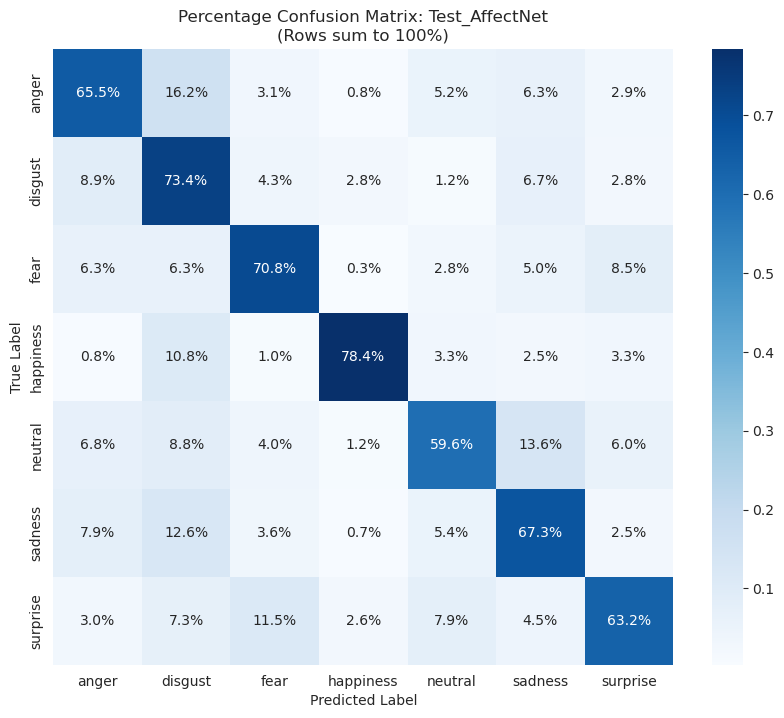


>>> Error Breakdown for Test_AffectNet:

[ANGER] Accuracy: 65.5%
   Most confused with:
    -> disgust: 16.2%
    -> sadness: 6.3%
    -> neutral: 5.2%

[DISGUST] Accuracy: 73.4%
   Most confused with:
    -> anger: 8.9%
    -> sadness: 6.7%
    -> fear: 4.3%

[FEAR] Accuracy: 70.8%
   Most confused with:
    -> surprise: 8.5%
    -> anger: 6.3%
    -> disgust: 6.3%

[HAPPINESS] Accuracy: 78.4%
   Most confused with:
    -> disgust: 10.8%
    -> neutral: 3.3%
    -> surprise: 3.3%

[NEUTRAL] Accuracy: 59.6%
   Most confused with:
    -> sadness: 13.6%
    -> disgust: 8.8%
    -> anger: 6.8%

[SADNESS] Accuracy: 67.3%
   Most confused with:
    -> disgust: 12.6%
    -> anger: 7.9%
    -> neutral: 5.4%

[SURPRISE] Accuracy: 63.2%
   Most confused with:
    -> fear: 11.5%
    -> neutral: 7.9%
    -> disgust: 7.3%

   Detailed Error Analysis: Test_FER2013


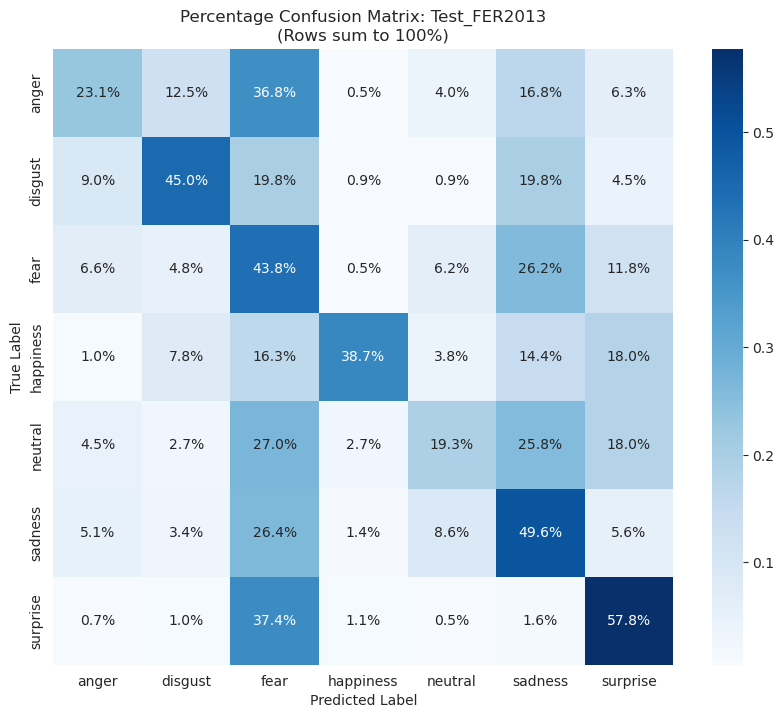


>>> Error Breakdown for Test_FER2013:

[ANGER] Accuracy: 23.1%
   Most confused with:
    -> fear: 36.8%
    -> sadness: 16.8%
    -> disgust: 12.5%

[DISGUST] Accuracy: 45.0%
   Most confused with:
    -> fear: 19.8%
    -> sadness: 19.8%
    -> anger: 9.0%

[FEAR] Accuracy: 43.8%
   Most confused with:
    -> sadness: 26.2%
    -> surprise: 11.8%
    -> anger: 6.6%

[HAPPINESS] Accuracy: 38.7%
   Most confused with:
    -> surprise: 18.0%
    -> fear: 16.3%
    -> sadness: 14.4%

[NEUTRAL] Accuracy: 19.3%
   Most confused with:
    -> fear: 27.0%
    -> sadness: 25.8%
    -> surprise: 18.0%

[SADNESS] Accuracy: 49.6%
   Most confused with:
    -> fear: 26.4%
    -> neutral: 8.6%
    -> surprise: 5.6%

[SURPRISE] Accuracy: 57.8%
   Most confused with:
    -> fear: 37.4%
    -> sadness: 1.6%
    -> happiness: 1.1%

   Detailed Error Analysis: Test_CKPlus


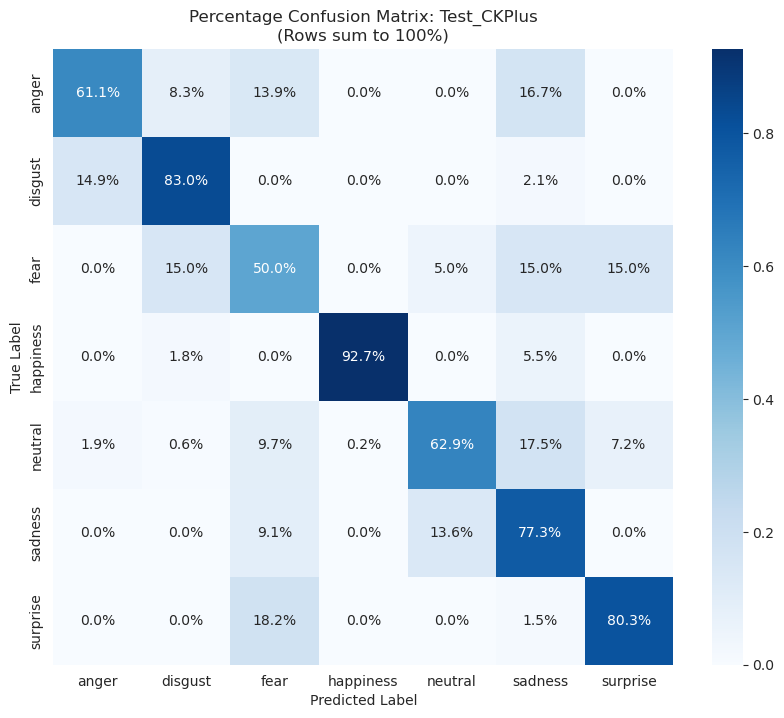


>>> Error Breakdown for Test_CKPlus:

[ANGER] Accuracy: 61.1%
   Most confused with:
    -> sadness: 16.7%
    -> fear: 13.9%
    -> disgust: 8.3%

[DISGUST] Accuracy: 83.0%
   Most confused with:
    -> anger: 14.9%
    -> sadness: 2.1%

[FEAR] Accuracy: 50.0%
   Most confused with:
    -> disgust: 15.0%
    -> sadness: 15.0%
    -> surprise: 15.0%

[HAPPINESS] Accuracy: 92.7%
   Most confused with:
    -> sadness: 5.5%
    -> disgust: 1.8%

[NEUTRAL] Accuracy: 62.9%
   Most confused with:
    -> sadness: 17.5%
    -> fear: 9.7%
    -> surprise: 7.2%

[SADNESS] Accuracy: 77.3%
   Most confused with:
    -> neutral: 13.6%
    -> fear: 9.1%

[SURPRISE] Accuracy: 80.3%
   Most confused with:
    -> fear: 18.2%
    -> sadness: 1.5%


In [41]:
# --- BLOCK 5: Percentage-Based Error Analysis ---
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 1. Setup
best_model_name = "Model_AffectNet"
model_info = models_config[best_model_name]

print(f"Loading best model: {best_model_name}...")
best_model = tf.keras.models.load_model(model_info['path'])
target_size = model_info['size']
class_names = None

def analyze_errors_percentage(model, data_path, dataset_name, img_size):
    global class_names
    print(f"\n=======================================================")
    print(f"   Detailed Error Analysis: {dataset_name}")
    print(f"=======================================================")

    # Load Data
    test_data = tf.keras.utils.image_dataset_from_directory(
        data_path,
        image_size=(img_size, img_size),
        batch_size=32,
        label_mode='categorical',
        shuffle=False,
        verbose=0
    )

    if class_names is None:
        class_names = test_data.class_names

    # Get Predictions
    y_true = np.concatenate([y for x, y in test_data], axis=0)
    y_true_indices = np.argmax(y_true, axis=1)

    y_pred_raw = model.predict(test_data, verbose=0)
    y_pred_indices = np.argmax(y_pred_raw, axis=1)

    # --- 1. NORMALIZED Confusion Matrix (The % View) ---
    # normalize='true' means: "Divide by the total number of TRUE images of that class"
    cm_pct = confusion_matrix(y_true_indices, y_pred_indices, normalize='true')

    # Plotting
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_pct,
                annot=True,
                fmt='.1%',    # Format as percentage (e.g. 15.2%)
                cmap='Blues', # Darker blue = Higher percentage
                xticklabels=class_names,
                yticklabels=class_names)

    plt.title(f"Percentage Confusion Matrix: {dataset_name}\n(Rows sum to 100%)")
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # --- 2. Text Breakdown of WHERE the errors go ---
    print(f"\n>>> Error Breakdown for {dataset_name}:")

    for i, label in enumerate(class_names):
        # The diagonal (i, i) is the Accuracy for this class
        accuracy = cm_pct[i, i] * 100
        print(f"\n[{label.upper()}] Accuracy: {accuracy:.1f}%")

        # Check the errors (everything not on the diagonal)
        errors = []
        for j, other_label in enumerate(class_names):
            if i != j: # Don't count the correct prediction
                pct = cm_pct[i, j] * 100
                if pct > 1.0: # Only show errors bigger than 1%
                    errors.append((other_label, pct))

        # Sort errors from biggest to smallest
        errors.sort(key=lambda x: x[1], reverse=True)

        if errors:
            print("   Most confused with:")
            for err_label, err_pct in errors[:3]: # Show top 3 mistakes
                print(f"    -> {err_label}: {err_pct:.1f}%")
        else:
            print("   (Almost perfectly predicted)")

# Run Analysis
for dataset_name, dataset_path in datasets_config.items():
    analyze_errors_percentage(best_model, dataset_path, dataset_name, target_size)

Loading Model_AffectNet...
Loading Double_96_data...

Analyzing Class: FEAR...


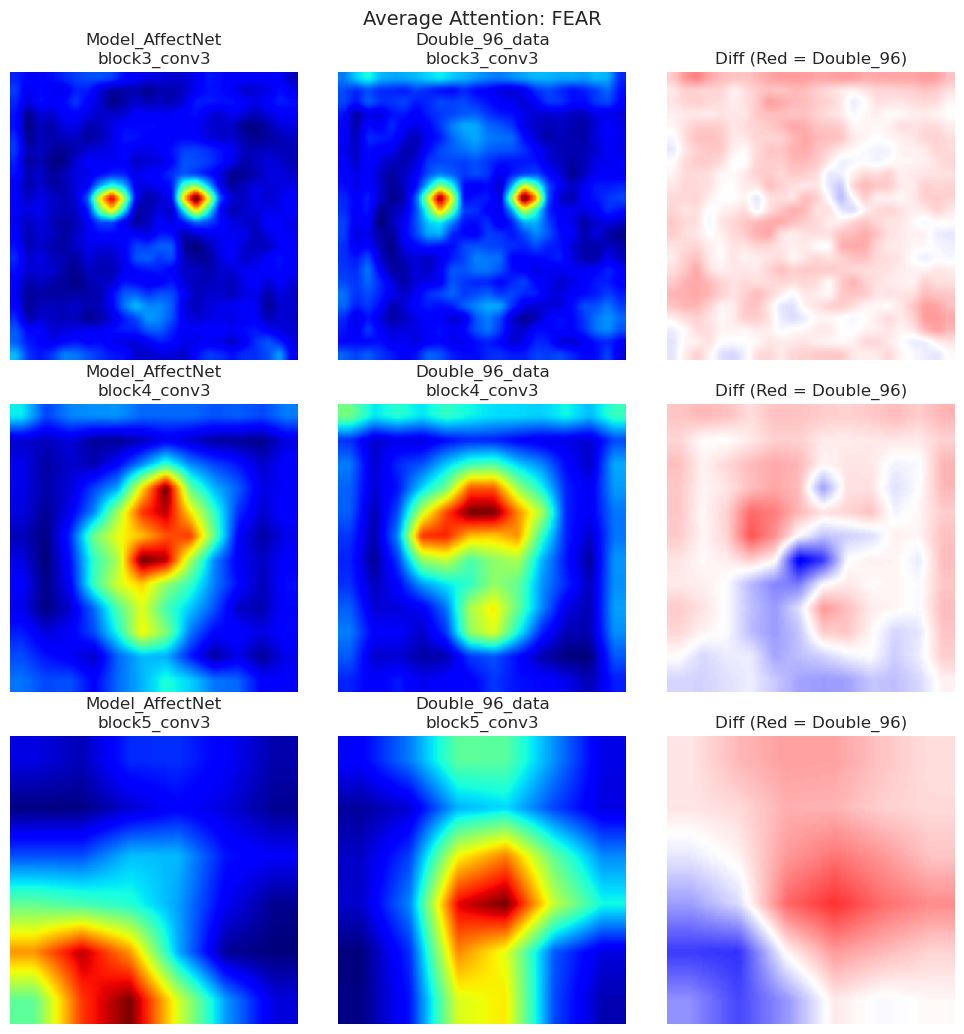


Analyzing Class: SURPRISE...


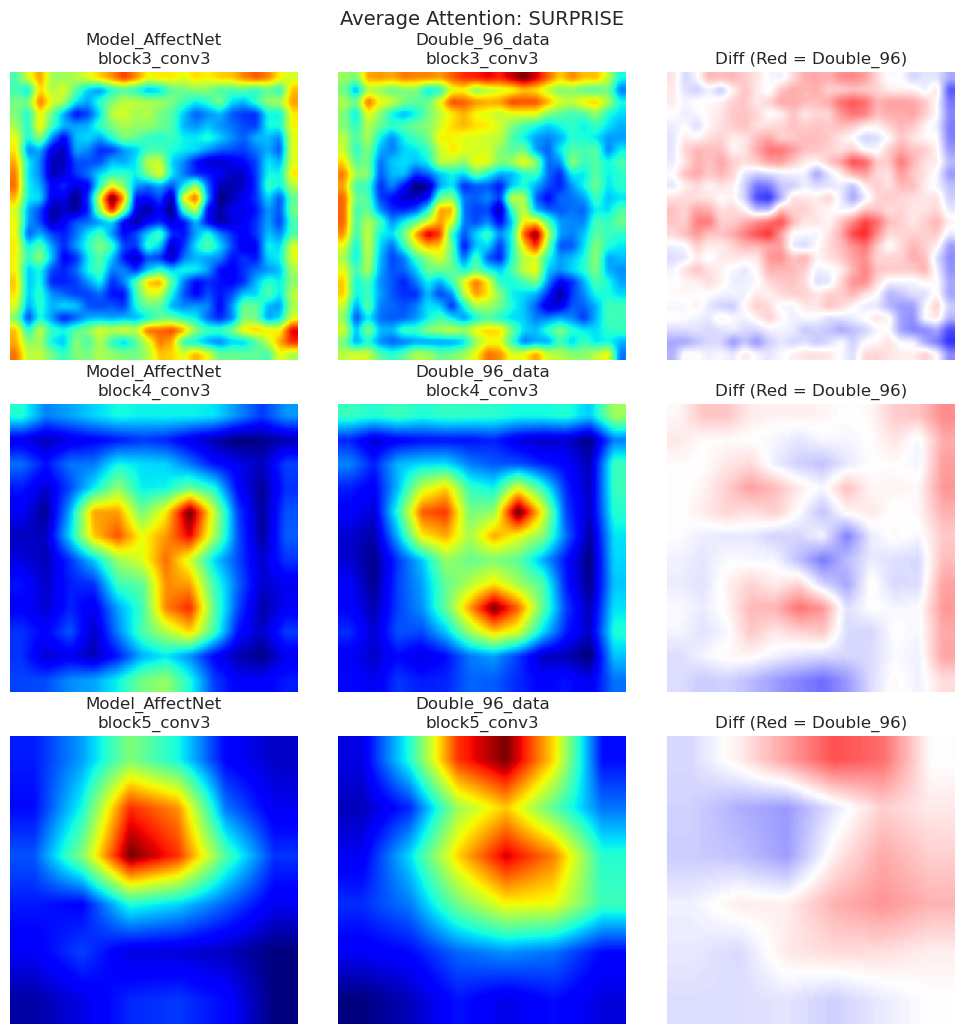


Analyzing Class: HAPPINESS...


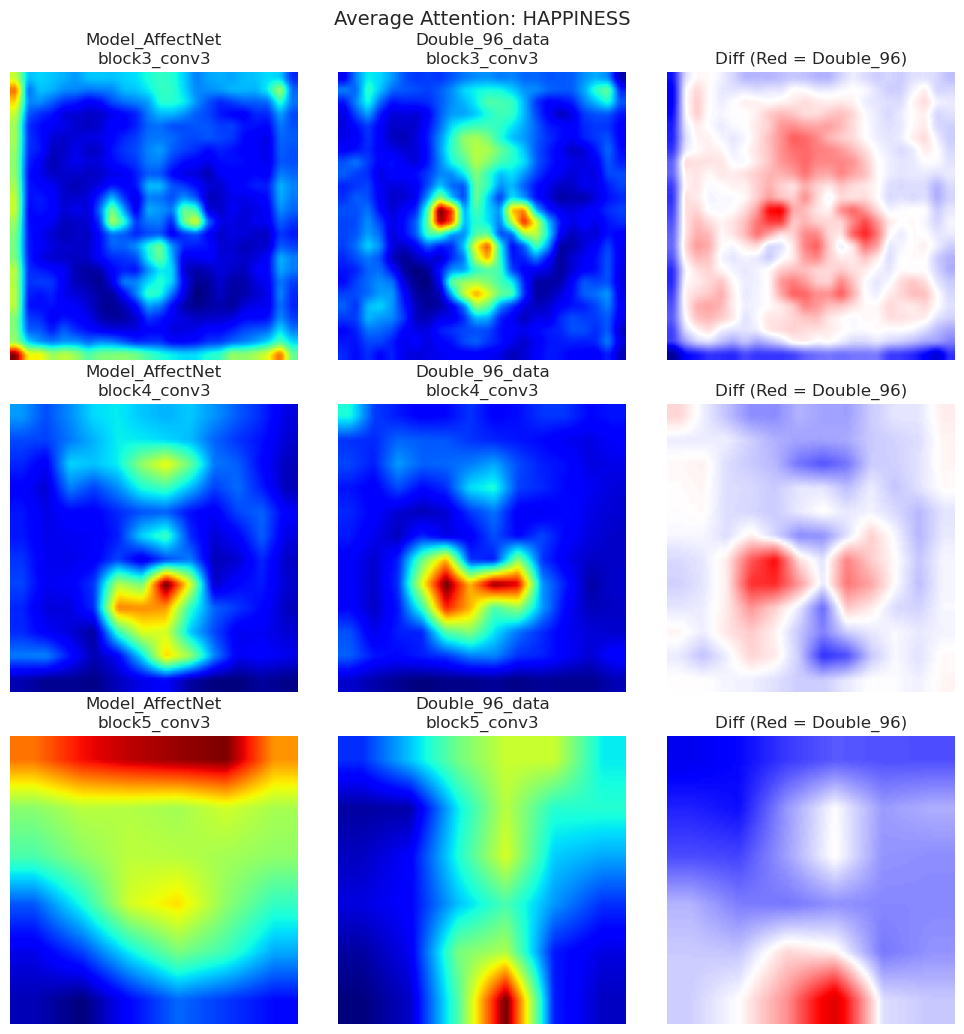


Analyzing Class: ANGER...


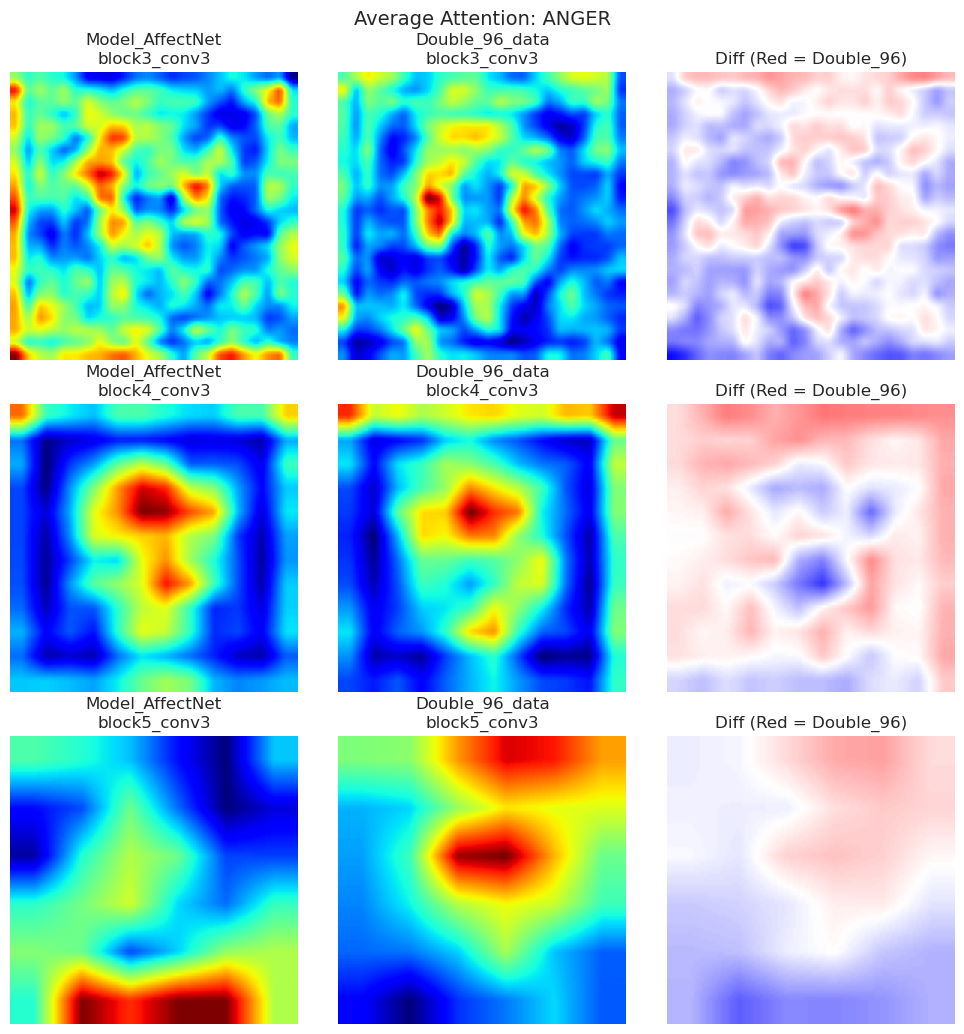

In [47]:
# --- BLOCK 6: Robust Comparative Analysis (Simplified) ---
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
import os
import cv2

# --- CONFIGURATION ---
model_A_name = "Model_AffectNet"
model_B_name = "Double_96_data"
test_dataset_path = datasets_config["Test_AffectNet"]

classes_to_compare = ['fear', 'surprise', 'happiness', 'anger']
layers_of_interest = ['block3_conv3', 'block4_conv3', 'block5_conv3']
N_IMAGES = 100

def get_heatmap_manual(model, img_array, layer_name):
    """
    Robust Grad-CAM that manually preprocces data to avoid Graph Disconnection errors.
    Assumes structure: [Input -> Rescaling/Augmentation -> VGG16 -> Classifier]
    """
    try:
        # 1. FIND PARTS
        vgg_layer = model.get_layer('vgg16')

        # Build VGG Gradient Model (VGG Inputs -> [Target Layer, VGG Output])
        vgg_grad_model = Model(
            inputs=vgg_layer.inputs,
            outputs=[vgg_layer.get_layer(layer_name).output, vgg_layer.output]
        )

        # Identify Classifier Layers (Everything AFTER vgg16)
        classifier_layers = []
        found_vgg = False
        for layer in model.layers:
            if layer.name == 'vgg16':
                found_vgg = True
                continue
            if found_vgg:
                classifier_layers.append(layer)

        # 2. PREPROCESS (Manual Override)
        # Instead of using the model's Rescaling layer, we do it manually.
        # This prevents "Graph Disconnected" errors.
        # Assumption: Rescaling is usually 1./255.
        vgg_input = img_array.astype('float32') / 255.0

        # 3. GRADIENT TAPE
        with tf.GradientTape() as tape:
            # Watch the manual input
            inputs = tf.cast(vgg_input, tf.float32)

            # Run VGG
            conv_out, vgg_out = vgg_grad_model(inputs)

            # Run Classifier
            x = vgg_out
            for layer in classifier_layers:
                x = layer(x, training=False)
            preds = x

            # Top Class Prediction
            pred_idx = tf.argmax(preds[0])
            loss = preds[:, pred_idx]

        # 4. GENERATE MAP
        grads = tape.gradient(loss, conv_out)
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
        conv_out = conv_out[0]

        heatmap = conv_out @ pooled_grads[..., tf.newaxis]
        heatmap = tf.squeeze(heatmap)
        heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)

        return heatmap.numpy()

    except Exception as e:
        # Fallback: Print error but return blank map so plot doesn't crash
        print(f"Heatmap Error ({layer_name}): {e}")
        return np.zeros((96, 96))

# --- MAIN LOOP ---

print(f"Loading {model_A_name}...")
model_A = tf.keras.models.load_model(models_config[model_A_name]['path'])
size_A = models_config[model_A_name]['size']

print(f"Loading {model_B_name}...")
model_B = tf.keras.models.load_model(models_config[model_B_name]['path'])
size_B = models_config[model_B_name]['size']

for emo_class in classes_to_compare:
    print(f"\nAnalyzing Class: {emo_class.upper()}...")

    # 3 Columns: Model A, Model B, Difference
    fig, axes = plt.subplots(len(layers_of_interest), 3, figsize=(10, 3.5 * len(layers_of_interest)))
    fig.suptitle(f"Average Attention: {emo_class.upper()}", fontsize=14)

    # Get Images
    class_dir = os.path.join(test_dataset_path, emo_class)
    images = [f for f in os.listdir(class_dir) if f.endswith(('.jpg', '.png'))][:N_IMAGES]

    for i, layer in enumerate(layers_of_interest):
        map_A_avg = np.zeros((96, 96))
        map_B_avg = np.zeros((96, 96))
        count = 0

        for img_file in images:
            img_path = os.path.join(class_dir, img_file)

            try:
                # MODEL A
                # Load Raw (0-255)
                img = load_img(img_path, target_size=(size_A, size_A))
                x_A = img_to_array(img)
                x_A = np.expand_dims(x_A, axis=0)

                # Generate
                hm_A = get_heatmap_manual(model_A, x_A, layer)

                # MODEL B
                img = load_img(img_path, target_size=(size_B, size_B))
                x_B = img_to_array(img)
                x_B = np.expand_dims(x_B, axis=0)

                # Generate
                hm_B = get_heatmap_manual(model_B, x_B, layer)

                # Accumulate (Resize for standard comparison)
                if np.max(hm_A) > 0 and np.max(hm_B) > 0:
                    map_A_avg += cv2.resize(hm_A, (96, 96))
                    map_B_avg += cv2.resize(hm_B, (96, 96))
                    count += 1
            except:
                pass

        # Normalize Average Map
        if count > 0:
            map_A_avg /= count
            map_B_avg /= count
            # Scale 0-1
            map_A_avg /= np.max(map_A_avg) + 1e-7
            map_B_avg /= np.max(map_B_avg) + 1e-7

        # PLOTTING
        # Row Select
        ax_a = axes[i, 0] if len(layers_of_interest) > 1 else axes[0]
        ax_b = axes[i, 1] if len(layers_of_interest) > 1 else axes[1]
        ax_c = axes[i, 2] if len(layers_of_interest) > 1 else axes[2]

        ax_a.imshow(map_A_avg, cmap='jet')
        ax_a.set_title(f"{model_A_name}\n{layer}")
        ax_a.axis('off')

        ax_b.imshow(map_B_avg, cmap='jet')
        ax_b.set_title(f"{model_B_name}\n{layer}")
        ax_b.axis('off')

        # Difference Map
        diff = map_B_avg - map_A_avg
        ax_c.imshow(diff, cmap='seismic', vmin=-1, vmax=1)
        ax_c.set_title("Diff (Red = Double_96)")
        ax_c.axis('off')

    plt.tight_layout()
    plt.show()

Loading models...
Starting comparison...

--- FEAR ---


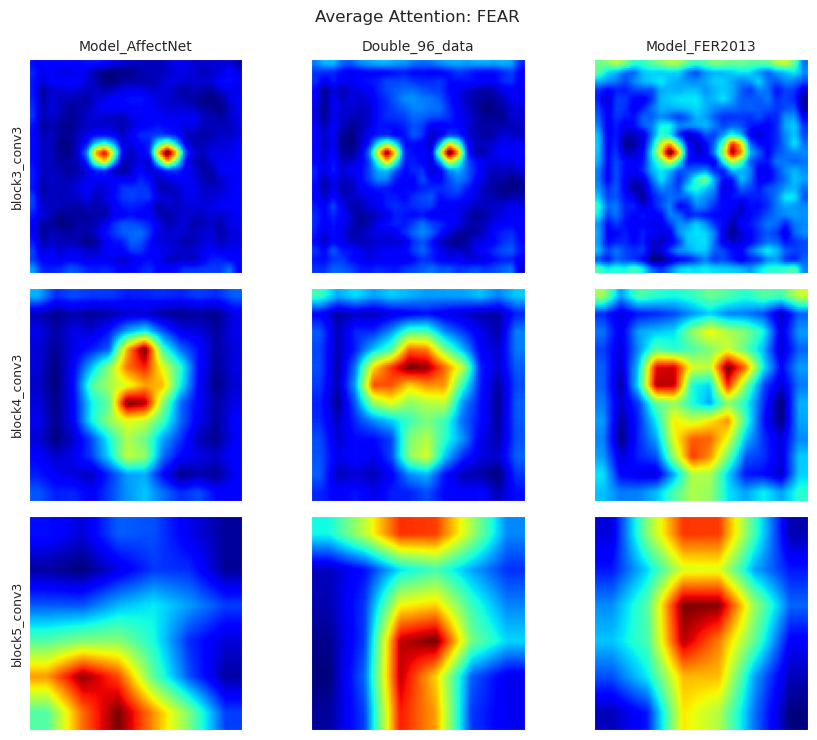


--- SURPRISE ---


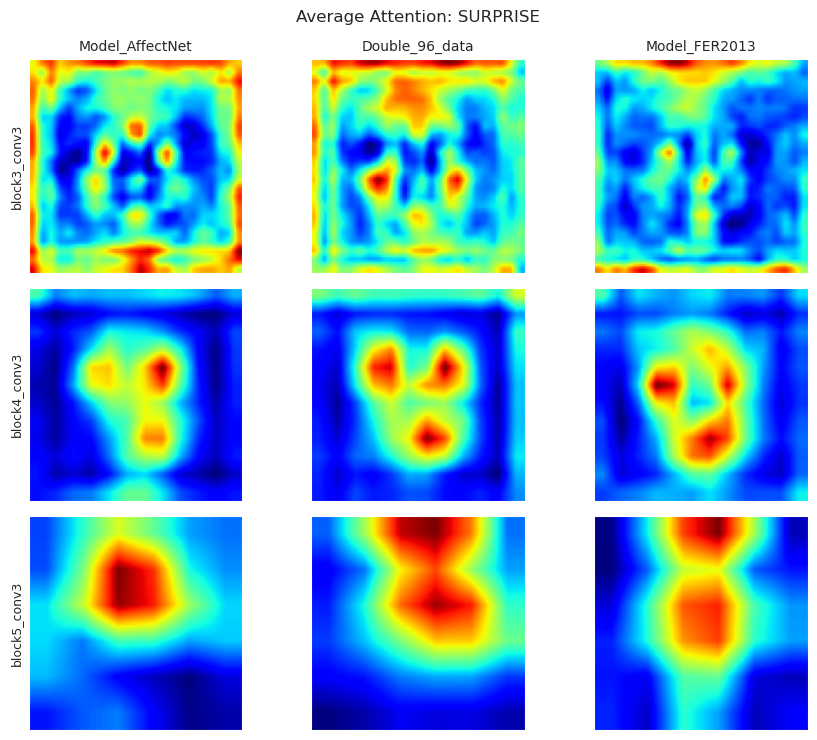


--- HAPPINESS ---


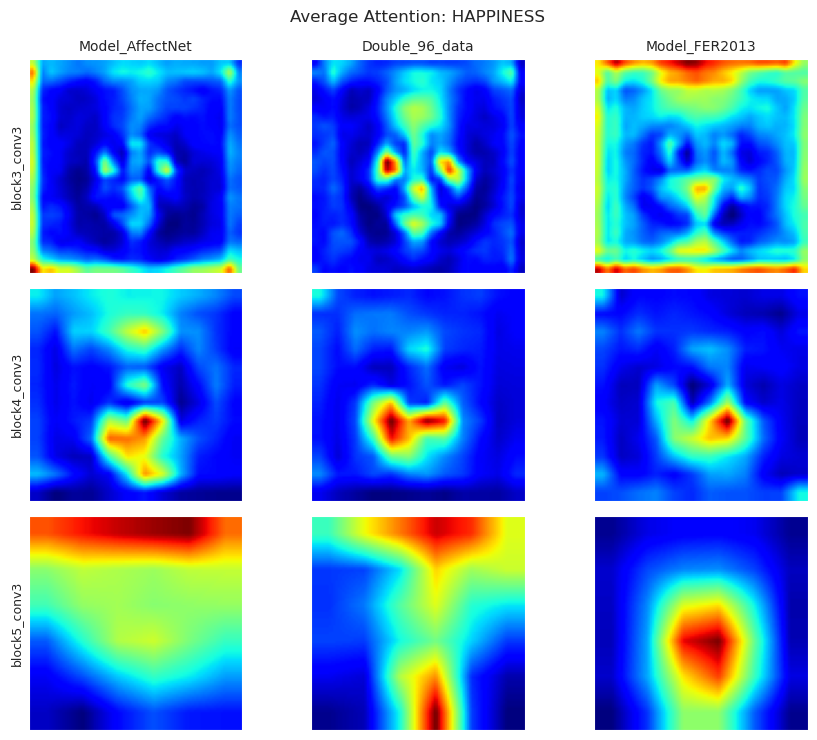


--- ANGER ---


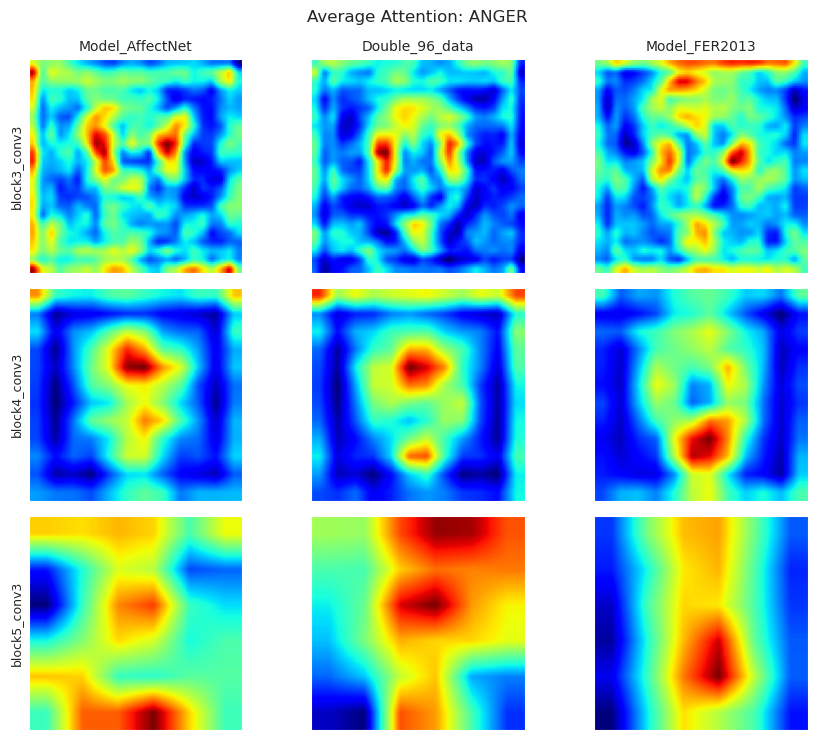

In [51]:
# --- BLOCK 6: Three-Model Comparative Analysis (Compact) ---
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
import os
import cv2

# --- CONFIGURATION ---
model_A_name = "Model_AffectNet"   # The Specialist
model_B_name = "Double_96_data"    # The Generalist
model_C_name = "Model_FER2013"     # The Baseline (Low Res)

test_dataset_path = datasets_config["Test_AffectNet"]
classes_to_compare = ['fear', 'surprise', 'happiness', 'anger']
layers_of_interest = ['block3_conv3', 'block4_conv3', 'block5_conv3']# Reduced to 2 layers to save screen space
N_IMAGES = 200

def get_heatmap_manual(model, img_array, layer_name):
    """
    Robust Grad-CAM with manual preprocessing (1/255) to avoid graph errors.
    """
    try:
        # 1. FIND PARTS
        vgg_layer = model.get_layer('vgg16')

        # Build VGG Gradient Model
        vgg_grad_model = Model(
            inputs=vgg_layer.inputs,
            outputs=[vgg_layer.get_layer(layer_name).output, vgg_layer.output]
        )

        # Identify Classifier Layers
        classifier_layers = []
        found_vgg = False
        for layer in model.layers:
            if layer.name == 'vgg16': found_vgg = True; continue
            if found_vgg: classifier_layers.append(layer)

        # 2. PREPROCESS (Manual 1/255 to mimic Rescaling)
        vgg_input = img_array.astype('float32') / 255.0

        # 3. GRADIENT TAPE
        with tf.GradientTape() as tape:
            inputs = tf.cast(vgg_input, tf.float32)
            conv_out, vgg_out = vgg_grad_model(inputs)

            x = vgg_out
            for layer in classifier_layers:
                x = layer(x, training=False)
            preds = x

            pred_idx = tf.argmax(preds[0])
            loss = preds[:, pred_idx]

        # 4. GENERATE MAP
        grads = tape.gradient(loss, conv_out)
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
        conv_out = conv_out[0]

        heatmap = conv_out @ pooled_grads[..., tf.newaxis]
        heatmap = tf.squeeze(heatmap)
        heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)

        return heatmap.numpy()

    except Exception as e:
        return np.zeros((96, 96)) # Return blank on error

# --- MAIN LOOP ---

print("Loading models...")
# Load all 3 models
mA = tf.keras.models.load_model(models_config[model_A_name]['path'])
size_A = models_config[model_A_name]['size']

mB = tf.keras.models.load_model(models_config[model_B_name]['path'])
size_B = models_config[model_B_name]['size']

mC = tf.keras.models.load_model(models_config[model_C_name]['path'])
size_C = models_config[model_C_name]['size']

print("Starting comparison...")

for emo_class in classes_to_compare:
    print(f"\n--- {emo_class.upper()} ---")

    # COMPACT LAYOUT: figsize=(9, 5) fits nicely on standard screens
    fig, axes = plt.subplots(len(layers_of_interest), 3, figsize=(9, 2.5 * len(layers_of_interest)))
    fig.suptitle(f"Average Attention: {emo_class.upper()}", fontsize=12)

    # Get Images
    class_dir = os.path.join(test_dataset_path, emo_class)
    images = [f for f in os.listdir(class_dir) if f.endswith(('.jpg', '.png'))][:N_IMAGES]

    for i, layer in enumerate(layers_of_interest):
        map_A, map_B, map_C = np.zeros((96,96)), np.zeros((96,96)), np.zeros((96,96))
        count = 0

        for img_file in images:
            try:
                img_path = os.path.join(class_dir, img_file)

                # MODEL A
                x_A = img_to_array(load_img(img_path, target_size=(size_A, size_A)))
                hm_A = get_heatmap_manual(mA, np.expand_dims(x_A, 0), layer)

                # MODEL B
                x_B = img_to_array(load_img(img_path, target_size=(size_B, size_B)))
                hm_B = get_heatmap_manual(mB, np.expand_dims(x_B, 0), layer)

                # MODEL C (New!)
                x_C = img_to_array(load_img(img_path, target_size=(size_C, size_C)))
                hm_C = get_heatmap_manual(mC, np.expand_dims(x_C, 0), layer)

                # Accumulate (Resize all to 96x96 for display)
                if np.max(hm_A) > 0 and np.max(hm_B) > 0 and np.max(hm_C) > 0:
                    map_A += cv2.resize(hm_A, (96, 96))
                    map_B += cv2.resize(hm_B, (96, 96))
                    map_C += cv2.resize(hm_C, (96, 96))
                    count += 1
            except: pass

        # Normalize
        if count > 0:
            for m in [map_A, map_B, map_C]:
                m /= count
                m /= (np.max(m) + 1e-7)

        # PLOTTING
        # Handle 1-layer case vs multi-layer case for axes
        if len(layers_of_interest) > 1:
            ax_rows = axes[i]
        else:
            ax_rows = axes

        # Plot A
        ax_rows[0].imshow(map_A, cmap='jet')
        if i == 0: ax_rows[0].set_title(model_A_name, fontsize=10)
        ax_rows[0].set_ylabel(layer, fontsize=9)
        ax_rows[0].set_xticks([]); ax_rows[0].set_yticks([])

        # Plot B
        ax_rows[1].imshow(map_B, cmap='jet')
        if i == 0: ax_rows[1].set_title(model_B_name, fontsize=10)
        ax_rows[1].set_xticks([]); ax_rows[1].set_yticks([])

        # Plot C
        ax_rows[2].imshow(map_C, cmap='jet')
        if i == 0: ax_rows[2].set_title(model_C_name, fontsize=10)
        ax_rows[2].set_xticks([]); ax_rows[2].set_yticks([])

    plt.tight_layout()
    plt.show()

In [35]:
# --- DIAGNOSTIC TOOL: Check Model Layers ---
model_name = "Model_AffectNet"
print(f"Inspecting: {model_name}...")
model = tf.keras.models.load_model(models_config[model_name]['path'])

print(f"\nModel Type: {type(model)}")

# 1. Check Top-Level Layers
print("\n--- TOP LEVEL LAYERS ---")
for layer in model.layers:
    print(f"  {layer.name} ({layer.__class__.__name__})")

# 2. Hunt for 'block5_conv3'
target = 'block5_conv3'
print(f"\n--- HUNTING FOR '{target}' ---")

# Strategy A: Direct
try:
    l = model.get_layer(target)
    print(f"SUCCESS: Found '{target}' directly in top level.")
except ValueError:
    print(f"FAILED: '{target}' not in top level.")

    # Strategy B: Inside VGG16 (or similar)
    # Look for any layer that looks like VGG
    vgg_candidates = [l for l in model.layers if 'vgg' in l.name.lower() or 'functional' in l.name.lower()]

    if vgg_candidates:
        for vgg_layer in vgg_candidates:
            print(f"Checking inside nested layer: '{vgg_layer.name}'...")
            try:
                # We need to access the inner model/layer logic depending on Keras version
                # Usually .get_layer() works on the layer object if it's a Functional/Model layer
                l = vgg_layer.get_layer(target)
                print(f"SUCCESS: Found '{target}' inside '{vgg_layer.name}'!")
            except Exception as e:
                print(f"  -> Not found in '{vgg_layer.name}'. Error: {e}")
                # List layers inside this nested one to help debug
                try:
                    # Some Keras versions allow iterating sub-layers
                    if hasattr(vgg_layer, 'layers'):
                        sub_names = [sl.name for sl in vgg_layer.layers]
                        print(f"     Sub-layers: {sub_names[:5]} ... {sub_names[-5:]}")
                except:
                    pass
    else:
        print("NO nested VGG candidates found.")

Inspecting: Model_AffectNet...

Model Type: <class 'keras.src.models.functional.Functional'>

--- TOP LEVEL LAYERS ---
  input_layer_4 (InputLayer)
  sequential_1 (Sequential)
  rescaling_1 (Rescaling)
  vgg16 (Functional)
  global_average_pooling2d_1 (GlobalAveragePooling2D)
  batch_normalization_1 (BatchNormalization)
  dense_2 (Dense)
  dropout_1 (Dropout)
  dense_3 (Dense)

--- HUNTING FOR 'block5_conv3' ---
FAILED: 'block5_conv3' not in top level.
Checking inside nested layer: 'vgg16'...
SUCCESS: Found 'block5_conv3' inside 'vgg16'!
